In [3]:
import alkanes
from utils import *
import envs

import time

import nglview as nv
from rdkit import Chem, DataStructs, RDConfig, rdBase
from rdkit import rdBase
from rdkit.Chem import AllChem, TorsionFingerprints
from rdkit.Chem import Draw,PyMol,rdFMCS
from rdkit.Chem.Draw import IPythonConsole
import json
import tqdm
import numpy as np

import numpy as np

In [23]:
mol = Chem.MolFromMolFile('258-trihexyl-decane.mol')
standard = 14.88278294332602
mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
print(res[0])
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

0


In [24]:
c = mol.GetConformer(id=0)

In [25]:
mol.AddConformer(c, assignId=True)

1

In [31]:
mol.GetConformer(id=-1).GetId()

0

In [4]:
def load_from_sdf(sdf_file):
    """
    """
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False) #, strictParsing=False
    sdf_mols = [mol for mol in suppl]
    return sdf_mols

In [ ]:
mols = load_from_sdf('./alkanes/alkanes.sdf') 

x = [
    [-60.00000000000001, 180.0, -59.99999999999999, -59.99999999999993, -59.99999999999993, -60.0000000000001, 59.999999999999986],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999996],
    [59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997],
    [-180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0],
    [180.0, 180.0, -180.0, 180.0, 60.00000000000001, -59.999999999999986, -180.0],
    [180.0, 180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999999, 179.99999999999997],
    [-59.99999999999999, 180.0, -180.0, 180.0, 59.99999999999996, -180.0, -180.0],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, -180.0, 59.999999999999986, -180.0],
    [-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0],
]

m = mols[-1]

m = Chem.rdmolops.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=10)
Chem.AllChem.MMFFOptimizeMoleculeConfs(m)
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)

for i, torsions in enumerate(x):
    conf = m.GetConformer(id=i)

    for idx, tors in enumerate(nonring):
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, x[i][idx])


rmslist = []
AllChem.AlignMolConformers(m, RMSlist=rmslist)

In [ ]:
nv.show_rdkit(m)

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#bababa', lw=8, label='Memory, All Actions'),
                   Line2D([0], [0], color='#ff6e42', lw=8, label='Memoryless, All Actions'),
                   Line2D([0], [0], color='#009a87', lw=8, label='Memory, Few Actions'),
                   Line2D([0], [0], color='#ee3375', lw=8, label='Memoryless, Few Actions'),
]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', prop={'size': 16})

plt.show()

In [ ]:
mols = load_from_sdf('./alkanes/alkanes.sdf') 
mols += load_from_sdf('./alkanes/pentane.sdf')
mols += load_from_sdf('./alkanes/heptane.sdf') 
mols += load_from_sdf('./alkanes/nonane.sdf') 
mols += load_from_sdf('./alkanes/11_alkane.sdf') 
mols += load_from_sdf('./alkanes/12_alkane.sdf') 
mols += load_from_sdf('./alkanes/14_alkane.sdf') 
mols += load_from_sdf('./alkanes/16_alkane.sdf') 
mols += load_from_sdf('./alkanes/18_alkane.sdf') 
mols += load_from_sdf('./alkanes/20_alkane.sdf') 

mols_by_rbn = {}

for mol in mols:
    m = Chem.rdmolops.AddHs(mol)
    AllChem.EmbedMolecule(m)
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)
    for tors in nonring:
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0)

    Chem.AllChem.MMFFOptimizeMolecule(m)

    atoms = m.GetNumAtoms()
    rbn = Chem.rdMolDescriptors.CalcNumRotatableBonds(m) - 2 
    print(rbn)
    mols_by_rbn[rbn] = m
  

In [ ]:
confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)  

energy_max = {}
for num, mol in sorted(mols_by_rbn.items()):
    energy = np.exp(-1.0 * confgen.get_conformer_energies(mol)[0])
    print(num, energy)
    energy_max[num] = energy

In [ ]:
def get_n(rbn):
    if rbn <= 3:
        n = 25
    elif rbn == 4 or rbn == 5:
        n = 50
    elif rbn == 6 or rbn == 7:
        n = 100
    else:
        n = 200
        
    return n

In [ ]:
from itertools import product
from sortedcontainers import SortedList
import time
import numpy as np

n_s = []
z_max_s = []
for num, m in sorted(mols_by_rbn.items()):

#     m = mols_by_rbn[3]
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)


    summ = 0
    combs = 0
    
    n = get_n(num)
    sl = SortedList()
    
    times = []
    for comb in product(*[[-1,0,1]] * num):
        ff = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(m, Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(m))
        desired_torsions = []
        for idx, tors in enumerate(nonring):

            atoms, ang = tors
            tup = atoms[0]
            deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
            Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0 + 120 * comb[idx])
            tors = 180.0 + 120 * comb[idx]
            desired_torsions.append(tors)
            ff.MMFFAddTorsionConstraint(*tup, False, tors, tors,  10000.0)

        ff.Initialize()
        start = time.process_time()
        ff.Minimize()
        times.append(time.process_time() - start)

        nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
        conf = m.GetConformer(id=0)
        tups = [atoms[0] for atoms, ang in nonring]
        degs = [Chem.rdMolTransforms.GetDihedralDeg(conf, *tup) for tup in tups]

        dist = np.linalg.norm(np.sin(np.array(degs) * np.pi / 180.) - np.sin(np.array(desired_torsions) * np.pi / 180.))
        dist += np.linalg.norm(np.cos(np.array(degs)* np.pi / 180.) - np.cos(np.array(desired_torsions) * np.pi / 180.))

        if dist > 0.1:
            print('desired torsions', desired_torsions)
            print('actual torsions', degs)
            print(dist)
            energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
            print(energy)
        
            raise Exception
        
        energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
        sl.add(energy)
        if len(sl) > n:
            sl.pop(0)
        summ += energy
        combs += 1
        
    print(num, 'total is', summ)
    print('number of conformations is', combs)
    print('max is', energy_max[num])
    print('Z/max ratio is', summ / energy_max[num])
    print('top n conformers is', sum(sl))
    print('mean time', np.array(times).mean())

    
    n_s.append(num)
    z_max_s.append(summ / energy_max[num])

In [ ]:
AllChem.MMFFOptimizeMoleculeConfs(m)
energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
print(energy)
nv.show_rdkit(m)


In [ ]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
conf = m.GetConformer(id=0)
ang = Chem.rdMolTransforms.GetDihedralDeg(conf, 3, 2, 1, 0)
print(tups, degs)
print(ang)
nv.show_rdkit(m)

In [ ]:
from rdkit.Geometry.rdGeometry import Point3D
def PointRotate3D(p1, p2, p0, theta):
    from numpy import cos, sin, sqrt

    # Translate so axis is at origin    
    p = p0 - p1
    # Initialize point q
    q = Point3D(0.0,0.0,0.0)
    N = (p2-p1)
    Nm = sqrt(N.x**2 + N.y**2 + N.z**2)
    
    # Rotation axis unit vector
    n = Point3D(N.x/Nm, N.y/Nm, N.z/Nm)

    # Matrix common factors     
    c = cos(theta)
    t = (1 - cos(theta))
    s = sin(theta)
    X = n.x
    Y = n.y
    Z = n.z

    # Matrix 'M'
    d11 = t*X**2 + c
    d12 = t*X*Y - s*Z
    d13 = t*X*Z + s*Y
    d21 = t*X*Y + s*Z
    d22 = t*Y**2 + c
    d23 = t*Y*Z - s*X
    d31 = t*X*Z - s*Y
    d32 = t*Y*Z + s*X
    d33 = t*Z**2 + c

    #            |p.x|
    # Matrix 'M'*|p.y|
    #            |p.z|
    q.x = d11*p.x + d12*p.y + d13*p.z
    q.y = d21*p.x + d22*p.y + d23*p.z
    q.z = d31*p.x + d32*p.y + d33*p.z

    # Translate axis and rotated point back to original location    
    return q + p1

In [ ]:
def setRingDihedralDeg(conf, iAtomId, jAtomId, kAtomId, lAtomId, value):
    rIJ = conf.GetAtomPosition(jAtomId) - conf.GetAtomPosition(iAtomId);
    rIJSqLength = rIJ.LengthSq();
    if (rIJSqLength <= 1.e-16):
        raise Exception("atoms i and j have identical 3D coordinates");

    rJK = conf.GetAtomPosition(kAtomId) - conf.GetAtomPosition(jAtomId);
    rJKSqLength = rJK.LengthSq();

    if (rJKSqLength <= 1.e-16):
        raise ValueErrorException("atoms j and k have identical 3D coordinates");

    rKL = conf.GetAtomPosition(lAtomId) - conf.GetAtomPosition(kAtomId);
    rKLSqLength = rKL.LengthSq()
    if (rKLSqLength <= 1.e-16):
        raise ValueErrorException("atoms k and l have identical 3D coordinates");

    nIJK = rIJ.CrossProduct(rJK);
    nIJKSqLength = nIJK.LengthSq();
    nJKL = rJK.CrossProduct(rKL);
    nJKLSqLength = nJKL.LengthSq();
    m1 = nIJK.CrossProduct(rJK);
    # we only need to rotate by delta with respect to the current dihedral value
    value *= (np.pi / 180)
    value -= -np.arctan2(m1.DotProduct(nJKL) / np.sqrt(nJKLSqLength * m1.LengthSq()),
                  nIJK.DotProduct(nJKL) / np.sqrt(nIJKSqLength * nJKLSqLength));
    # our rotation axis is the (j,k) bond
    rotAxisBegin = conf.GetAtomPosition(jAtomId);
    rotAxisEnd = conf.GetAtomPosition(kAtomId);
    rotAxis = rotAxisEnd - rotAxisBegin
    rotAxis.Normalize()
    # get all atoms bonded to k and loop through them
    # std::list<unsigned int> alist;
    # _toBeMovedIdxList(mol, jAtomId, kAtomId, alist);
    # for (unsigned int &it : alist) {
    # translate atom so that it coincides with the origin of rotation
    pos = conf.GetAtomPosition(lAtomId)

    # rotate around our rotation axis
    p = PointRotate3D(rotAxisBegin, rotAxisEnd, pos, value)
    conf.SetAtomPosition(lAtomId, p)

In [ ]:
def print_dihedrals(conf):
    m = conf.GetOwningMol()
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    print('nonring')
    for idx, tors in enumerate(nonring):
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        print(tup, deg)

#     print('ring')        
#     for tors in ring:
#         deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tors)
#         print(tors, deg)
#     print('\n\n\n')

In [ ]:
def add_torsion_constraints(ff, tors_list, rotate=0, minimize=False):
    tors_list = tors_list[rotate:] + tors_list[:rotate]
    
    tors = tors_list[0]
    ff.MMFFAddTorsionConstraint(0, 5, 4, 3, False, tors - 0.1, tors + 0.1, 10000.0)
    tors = tors_list[1]
    ff.MMFFAddTorsionConstraint(5, 4, 3, 2, False, tors - 0.1, tors + 0.1, 10000.0)
    tors = tors_list[2]
    ff.MMFFAddTorsionConstraint(4, 3, 2, 1, False, tors - 0.1, tors + 0.1,  10000.0)
    tors = tors_list[3]
    ff.MMFFAddTorsionConstraint(3, 2, 1, 0, False, tors - 0.1, tors + 0.1,  10000.0)
    tors = tors_list[4]
    ff.MMFFAddTorsionConstraint(2, 1, 0, 5, False, tors - 0.1, tors + 0.1,  10000.0)
    tors = tors_list[5]
    ff.MMFFAddTorsionConstraint(1, 0, 5, 4, False, tors - 0.1, tors + 0.1,  10000.0)


In [34]:
def get_radial_hist(series, N, title='decane φ histogram'):
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # make the histogram that bined on 24 hour
    radii, tick = np.histogram(torsions, bins = N)

    # width of each bin on the plot
    width = (2*np.pi) / N

    # make a polar plot
    plt.figure(figsize = (12, 8))
    ax = plt.subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=width, bottom=bottom)

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ticks = ['180/-180', '-135', '-90', '-45', '0', '45', '90', '135']
    ax.set_xticklabels(ticks)
    plt.title(title)
    plt.show()

In [ ]:
m = Chem.MolFromSmiles('C1CCCCC1')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=1)
res = AllChem.MMFFOptimizeMoleculeConfs(m)
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
ring = ring[0][0]

print_dihedrals(conf)
    
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

In [ ]:
ff = rdkit.Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(m, rdkit.Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(m))

# ff.MMFFAddTorsionConstraint(0, 5, 4, 3, False, 180.0, 180.0, 10000.0)
# ff.MMFFAddTorsionConstraint(5, 4, 3, 2, False, 180.0, 180.0, 10000.0)
# ff.MMFFAddTorsionConstraint(4, 3, 2, 1, False, 180.0, 180.0,  10000.0)
# ff.MMFFAddTorsionConstraint(3, 2, 1, 0, False, 180.0, 180.0,  10000.0)
# ff.MMFFAddTorsionConstraint(2, 1, 0, 5, False, 180.0, 180.0,  10000.0)
# ff.MMFFAddTorsionConstraint(1, 0, 5, 4, False, 180.0, 180.0,  10000.0)

# ff.MMFFAddTorsionConstraint(0, 5, 4, 3, False, -29.2, -29.0, 10000.0)
# ff.MMFFAddTorsionConstraint(5, 4, 3, 2, False, 60.0, 60.2, 10000.0)
# ff.MMFFAddTorsionConstraint(4, 3, 2, 1, False, -29.2, -29.0, 10000.0)
# ff.MMFFAddTorsionConstraint(3, 2, 1, 0, False, -29.2, -29.0, 10000.0)
# ff.MMFFAddTorsionConstraint(2, 1, 0, 5, False, 60.0, 60.2, 10000.0)
# ff.MMFFAddTorsionConstraint(1, 0, 5, 4, False, -29.2, -29.0, 10000.0)

add_torsion_constraints(ff, [-29.1675, 60.106, -29.1675, -29.1675, 60.106, -29.1675], rotate=1)


# add_torsion_constraints(ff, [-54.2, 54.2, -54.2, 54.2, -54.2, 54.2])


# add_torsion_constraints(ff, [-46, -26,  -5,  25, -13, 65])

ff.Initialize()
ret = ff.Minimize(maxIts=500)
print(ret)

# AllChem.MMFFOptimizeMolecule(m)


In [29]:
AllChem.MMFFOptimizeMoleculeConfs(m)
print_dihedrals(m.GetConformers()[0])
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

NameError: name 'print_dihedrals' is not defined

In [ ]:
import numpy as np
k = np.random.randint(-80, 80, size=(1,5))
print(k)
print(0 - k.sum())
help(np.random.randint)

In [36]:
lignin = Chem.MolFromMolFile('lignin_guaiacyl.mol')
lignin = Chem.AddHs(lignin)
AllChem.EmbedMultipleConfs(lignin, numConfs=200, numThreads=0)


In [37]:
AllChem.MMFFOptimizeMoleculeConfs(lignin, numThreads=0)
confgen = ConformerGeneratorCustom(max_conformers=200, 
                 rmsd_threshold=1.0, 
                 force_field='mmff',
                 pool_multiplier=1)  
energys = confgen.get_conformer_energies(lignin)


sum([np.exp(-1.0 * energy) for energy in energys])

5.245012221839363e-51

In [27]:
[np.exp(-1.0 * energy) for energy in energys]

[3.357272996980157e-55,
 4.6665202914887395e-53,
 1.2229960193701039e-53,
 1.814031427743306e-53,
 4.090794260376696e-54,
 7.393867555433174e-57,
 2.112891454249133e-54,
 7.354230066324086e-54,
 1.2845240259458374e-53,
 1.598126955843612e-54,
 7.765258584212556e-56,
 2.0944281844349845e-53,
 5.89998852049729e-54,
 3.4913701513249677e-53,
 7.198636578338594e-54,
 2.0893427950987513e-54,
 3.5760427193897606e-53,
 1.383530699179373e-53,
 1.2862426016678312e-53,
 3.4150537466692785e-52,
 3.062338745506074e-54,
 5.9409474500007e-55,
 2.4065839361057103e-53,
 5.723229727124177e-53,
 2.690714486786864e-54,
 1.1889594744179042e-54,
 6.84557884157465e-55,
 4.1807529713897463e-54,
 1.7460176341235494e-53,
 3.4200722683279486e-54,
 5.583898044148528e-54,
 1.2610856442345411e-55,
 4.8361271655838505e-54,
 1.718701086605728e-54,
 3.5328227915063064e-54,
 2.0305144518179226e-52,
 3.465868678373645e-54,
 5.15275372981341e-53,
 5.999443726897025e-57,
 1.7338979581457797e-53,
 3.348099660009558e-55,
 1

In [ ]:
from importlib import reload
reload(graphenvironments)


In [ ]:
print_dihedrals(lignin.GetConformer(id=65))

In [ ]:
out = np.array(AllChem.GetConformerRMSMatrix(lignin))
np.argmin(out)
out[2965]

In [ ]:
x = get_conformer_rmsd_fast(lignin)



In [ ]:
np.sum(x>4.05)

In [ ]:
np.nonzero(x>4.05)


In [21]:
#39,77 and 45,86 are very similar

print_dihedrals(lignin.GetConformer(33))
print_dihedrals(lignin.GetConformer(82))

NameError: name 'print_dihedrals' is not defined

In [23]:
import py3Dmol
p = py3Dmol.view(width=800,height=800)
drawit(lignin, p, confId=46)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
m = Chem.MolFromMolFile('258-trihexyl-decane.mol')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=200, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)

mol = m

nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
print(len(nonring))
p = py3Dmol.view(width=800,height=800)

drawit(m, p, confId=0)

22


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
energys = confgen.get_conformer_energies(m)
print(energys)
print(energys.min())
energys = energys - energys.min()

for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

[11.87496363 15.3631415  12.2908916  15.51338632 14.69805715 15.76855151
 11.41123807  8.93640337 12.53762168 16.60696803 12.665662   14.20227621
 11.93735264 12.13151474 12.60756399 12.01159283 14.0612914  17.12120193
  9.52853862 14.45071471  8.75726507 11.83794177 11.27474033 16.51826082
 14.34344008 13.11836222 14.30340815  9.30961908 12.40071799 11.32704038
  7.84334108  8.99689374 11.74786994  9.40034695 13.93876172  8.57750742
  8.23718754 17.6232886  14.57128556  8.3319542  11.89551114 16.37791594
 11.77458739 11.48683128 13.61601125 15.43703546  9.65399926 10.66956315
 12.15805601 17.51336472  9.79402112 11.48253816 14.16081735 11.51180758
  9.71837163 13.85159081 11.77458746 11.14352922 11.89354822 12.49645323
  8.12440379  8.87538785 18.09252563 14.26666265 14.96065614  8.58002895
 10.96486832 12.02698003 15.49153307 14.53175564 11.74577122 12.09759668
 10.47170473 14.66854679  9.11910311 11.87860594  9.47400986 13.08335809
  8.53257348  9.65547464  9.6441096  14.61279127 12

18.171534485122343

In [ ]:
m = Chem.MolFromSmiles('CCC(CC)CC(CCC)CCC')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=200, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)

mol = m

nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
print(len(nonring))


In [ ]:
p = py3Dmol.view(width=800,height=800)

drawit(mol, p, confId=0)

In [1]:
AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
confgen = ConformerGeneratorCustom(max_conformers=200, 
                 rmsd_threshold=1.0, 
                 force_field='mmff',
                 pool_multiplier=1)  
print(get_conformer_rmsd_fast(mol))
mol, mat = confgen.prune_conformers(mol, get_conformer_rmsd_fast(mol))
print(mat)
energys = confgen.get_conformer_energies(mol)
energys = energys - energys.min()

print(len(energys))
for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

NameError: name 'AllChem' is not defined

In [18]:
m = Chem.MolFromSmiles('CC(CCC)CCCC(CCCC)CC')
m = Chem.AddHs(m)
from time import time
start = time()
AllChem.EmbedMultipleConfs(m, numConfs=200, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)
print(time() - start)
mol = m

nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
print(len(nonring))

AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
confgen = ConformerGeneratorCustom(max_conformers=200, 
                 rmsd_threshold=1.5, 
                 force_field='mmff',
                 pool_multiplier=1)  
print(get_conformer_rmsd_fast(mol))
mol, mat = confgen.prune_conformers(mol, get_conformer_rmsd_fast(mol))
print(mat)
energys = confgen.get_conformer_energies(mol)
energys = energys - energys.min()

print(len(energys))
for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

4.455225944519043
10


Calculating RMSDs of conformer 14:   7%|▋         | 14/200 [00:00<00:03, 61.96it/s]

[[0.         1.91059233 2.33688216 ... 2.24599302 2.7073305  2.2688316 ]
 [1.91059233 0.         2.35657967 ... 2.10333149 2.30089104 2.18203042]
 [2.33688216 2.35657967 0.         ... 2.53266717 2.35137915 2.05311092]
 ...
 [2.24599302 2.10333149 2.53266717 ... 0.         1.90878229 2.3154856 ]
 [2.7073305  2.30089104 2.35137915 ... 1.90878229 0.         2.39566892]
 [2.2688316  2.18203042 2.05311092 ... 2.3154856  2.39566892 0.        ]]


Calculating RMSDs of conformer 171: 100%|██████████| 172/172 [00:01<00:00, 118.05it/s]


[[0.         2.80981874 2.26968319 ... 2.68136033 2.09318168 2.87678629]
 [2.80981874 0.         2.44623159 ... 2.04988301 2.60140768 2.19757529]
 [2.26968319 2.44623159 0.         ... 2.75923882 2.5753681  3.22664333]
 ...
 [2.68136033 2.04988301 2.75923882 ... 0.         2.27233501 2.29540394]
 [2.09318168 2.60140768 2.5753681  ... 2.27233501 0.         2.8978754 ]
 [2.87678629 2.19757529 3.22664333 ... 2.29540394 2.8978754  0.        ]]
172
0 171 10.718319673488068
1 170 10.474775988203998
2 169 10.249184551006444
3 168 9.886881808256444
4 167 9.779947520338865
5 166 9.670023638464414
6 165 9.562762338225479
7 164 9.27786085246803
8 163 9.056211775230988
9 162 8.93618741579387
10 161 8.763626947863582
11 160 8.674919741433758
12 159 8.53457485592698
13 158 8.518930347758868
14 157 8.223708584387623
15 156 8.136228179495488
16 155 8.125746982659924
17 154 7.925210428443576
18 153 7.6700452430385955
19 152 7.648191990785138
20 151 7.593694378374833
21 150 7.519800416458731
22 149 7.47

17.026874809591583

In [ ]:
print_dihedrals(lignin.GetConformer(4))

In [30]:
def bag_of_dihedrals(mol):
    import pandas as pd
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
    torsions = []
    for conf in mol.GetConformers():
        for idx, tors in enumerate(nonring):
            atoms, ang = tors
            tup = atoms[0]
            deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
            torsions.append(deg)
            
    return pd.Series(torsions)


In [38]:

torsions = bag_of_dihedrals(lignin)

torsions /= (180)


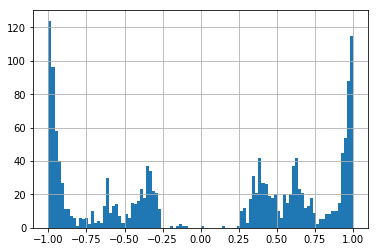

In [39]:
torsions.hist(bins=100)

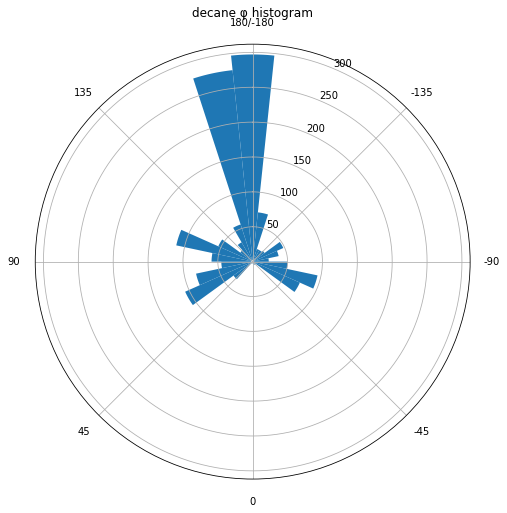

In [40]:
get_radial_hist(torsions * np.pi, 30)

In [ ]:
np.array([-1.0, -0.66, -.33, 0, .33, .66, 1]) * 180

In [ ]:
m = Chem.MolFromSmiles('CCCCCCCCCCCC')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=400, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

In [ ]:
torsions = bag_of_dihedrals(m)
torsions /= (180)
torsions.hist(bins=400)

In [ ]:
torsions *= 2*np.pi

In [ ]:
get_radial_hist(torsions, 100)

In [ ]:
torsions

In [ ]:
conf = m.GetConformer(0)
print_dihedrals(conf)

In [ ]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)


x = [
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
]

y = [
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
]

conf = m.GetConformer(id=0)

for idx, tors in enumerate(nonring):
    atoms, ang = tors
    tup = atoms[0]
    deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
    Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, x[idx])

conf = m.GetConformer(id=1)

for idx, tors in enumerate(nonring):
    atoms, ang = tors
    tup = atoms[0]
    deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
    Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, y[idx])
    
    


In [ ]:
m.GetConformers()

In [ ]:
confgen.get_conformer_energies(m)

In [ ]:
AllChem.GetConformerRMS(m, 0, 1)

In [ ]:
Chem.TorsionFingerprints.GetTFDBetweenConformers(m, [0], [1])

In [ ]:
p = py3Dmol.view(width=800,height=800)
drawit(m, p, confId=0)

In [ ]:
AllChem.MMFFOptimizeMoleculeConfs(m)
print(confgen.get_conformer_energies(m))
print(AllChem.GetConformerRMS(m, 0, 1))
print(Chem.TorsionFingerprints.GetTFDBetweenConformers(m, [0], [1]))

In [ ]:
conf = lignin.GetConformer(id=-1)

In [ ]:
torch.Tensor(conf.GetPositions())

In [ ]:
import torch

In [ ]:
atom = lignin.GetAtomWithIdx(0)

In [ ]:
atom.GetIdx()

In [ ]:
conf.GetOwningMol()

In [ ]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(lignin)
print(nonring)
print('\n')
print(ring)

In [ ]:
def bond_features(bond, use_chirality=False):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)
 
#################
# pen added
#################
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def atom_features_simple(atom, conf):
    p = conf.GetAtomPosition(atom.GetIdx())
    return np.array([p.x, p.y, p.z])


def mol2vecsimple(mol):
    conf = mol.GetConformer(id=-1)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features_simple(atom, conf) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond, use_chirality=False) for bond in bonds]
    for bond in bonds:
        edge_attr.append(bond_features(bond))
    data = Data(
                x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr,dtype=torch.float),
                pos=torch.Tensor(conf.GetPositions())
            )
    data = Distance()(data)
    return data    



In [ ]:
conf = lignin.GetConformer(id=0)

In [ ]:
conf.GetPositions()

In [ ]:
x = lignin.GetConformer(id=1).GetPositions()

In [ ]:
x[0][0] = 0

In [ ]:
lignin.GetConformer(id=1).GetPositions()

In [ ]:
x = lignin.GetConformer(id=1).GetPositions()

In [ ]:
from time import time
start = time()

[lignin.GetConformer(id=1).SetAtomPosition(i, Point3D(0,0,0)) for i,atom in enumerate(x)]


In [2]:
lignin = Chem.MolFromMolFile('lignin_guaiacyl.mol')
lignin = Chem.AddHs(lignin)
from time import time
start = time()
AllChem.EmbedMultipleConfs(lignin, numConfs=1, numThreads=0)
Chem.AllChem.MMFFOptimizeMoleculeConfs(lignin)
print(time()- start)

0.10225224494934082


In [3]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(lignin)
print(nonring)

[([(2, 1, 4, 5)], 180.0), ([(4, 1, 2, 14)], 180.0), ([(4, 1, 0, 3)], 180.0), ([(6, 5, 4, 1)], 180.0), ([(5, 6, 11, 12)], 180.0), ([(15, 14, 2, 1)], 180.0), ([(22, 20, 18, 19)], 180.0), ([(23, 21, 19, 18)], 180.0)]


In [4]:
len(nonring)

8

In [5]:
import graphenvironments
import gym
gym.envs.register(
     id='Lignin-v0',
     entry_point='graphenvironments:LigninEnv',
     max_episode_steps=1000,
)

gym.envs.register(
     id='Lignin-v1',
     entry_point='graphenvironments:LigninSetEnv',
     max_episode_steps=1000,
)


gym.envs.register(
     id='Carbon-v0',
     entry_point='graphenvironments:BranchedCarbonSet',
     max_episode_steps=1000,
)

gym.envs.register(
     id='Trihexyl-v0',
     entry_point='graphenvironments:TrihexylSet',
     max_episode_steps=1000,
)

In [6]:
import gym
gym.envs.register(
     id='UnholySet-v0',
     entry_point='graphenvironments:UnholySet',
     max_episode_steps=1000,
)

In [11]:
env = gym.make('UnholySet-v0')

In [10]:
from importlib import reload
reload(graphenvironments)


<module 'graphenvironments' from '/home/tgog/conformer-ml/graphenvironments.py'>

In [12]:
env.reset()

step time mean nan
reset called
[-179.83367935906404, -176.09884497684226, -66.42051037597219, -168.53846104558522, -65.88287566849853, -171.41715041010968, 155.34583124411466, 166.0750523383471, -176.35756191709294, -67.51600983218302]


/home/tgog/conformer-ml/graphenvironments.py:817: RuntimeWarning: Mean of empty slice.


(Batch(batch=[50], edge_attr=[98, 7], edge_index=[2, 98], pos=[50, 3], x=[50, 3]),
 [[0, 1, 2, 3],
  [1, 2, 3, 4],
  [2, 3, 4, 5],
  [3, 4, 5, 6],
  [4, 5, 6, 9],
  [5, 6, 7, 8],
  [5, 6, 9, 10],
  [6, 9, 11, 12],
  [9, 11, 12, 13],
  [11, 12, 13, 14]])

In [13]:
done = False
rewards = 0
while not done:
    _, reward, done, _ = env.step(np.random.randint(0,6,10))
    print(reward)
    rewards += reward
    
print(rewards)

action is  [1 5 3 5 4 1 1 3 2 2]
standard 15.125028670400216
current [24.68611221]
reward is  7.041645808286449e-05
new state is:
[63.8008925649859, 64.9302876718195, -98.28424650942769, 179.5732064646188, 79.48920970426522, -169.05311266149513, -70.01161277964465, 63.76805827043718, -97.39930297008684, -61.59746958707969]
7.041645808286449e-05
action is  [4 5 1 5 5 5 2 1 2 2]
standard 15.125028670400216
current [25.73273898]
reward is  2.4724638345600302e-05
new state is:
[62.20427150356124, 66.04713271980552, -97.56420259961554, -175.1699720469855, 90.35041009679136, 88.91654286209702, -47.762333595223474, 175.00195879627398, -56.51748447383016, -58.648853434364824]
2.4724638345600302e-05
action is  [3 1 0 5 1 5 5 5 3 2]
standard 15.125028670400216
current [17.47023118]
reward is  0.09582779452396664
new state is:
[62.859342000462796, 176.32743661350054, 177.51168204366698, 172.5925560083679, -169.23423680520995, -177.25148826878458, 155.77869927469857, 175.31498917483182, -58.261909

standard 15.125028670400216
current [14.70281245]
reward is  1.5253383033591785
new state is:
[-179.1978999007679, 179.0334754644985, 61.30748527569022, 62.38963289586192, -164.23263942395124, -179.62202206391942, -60.854212136087774, 61.94081348998535, -178.04860634182035, -63.2871186704871]
1.5253383033591785
action is  [3 5 2 2 1 0 1 1 5 5]
standard 15.125028670400216
current [22.5196496]
reward is  0.0006145495927446487
new state is:
[66.3217038347517, 91.47379913941694, -69.9803726144116, -57.55286232518232, -54.91774238408149, -72.59943526755897, 175.7419320489613, -63.18580383079531, -165.63963798897757, 67.56344516790062]
0.0006145495927446487
action is  [0 0 0 0 1 2 0 5 0 4]
standard 15.125028670400216
current [16.42221992]
reward is  0.2732983417357569
new state is:
[179.99306634309636, -179.98989062526823, -179.58069039252055, -178.72230346446537, -136.82572989036632, -62.20722774340117, 167.15337930162167, 168.04993562939737, -174.74275522478524, 64.84625544383415]
0.273298

standard 15.125028670400216
current [26.9017868]
reward is  7.681020610950084e-06
new state is:
[-67.90066696207, -176.31459161812703, -95.03320819702725, 72.21495979601022, 132.83143871095461, 163.08901084547392, -159.17516856025014, 94.94022939396483, -172.7775622990014, -58.25064125513752]
7.681020610950084e-06
action is  [5 3 2 4 2 0 2 2 2 1]
standard 15.125028670400216
current [28.38319045]
reward is  1.7460372247860153e-06
new state is:
[69.48196541930979, -90.98086787153684, -67.02463931416642, 105.26554812377536, -169.06820465353945, 39.6962431703636, -55.62687183178296, 119.27618430173855, -70.87228902183085, 166.14838986587378]
1.7460372247860153e-06
action is  [2 1 0 1 5 1 3 5 2 3]
standard 15.125028670400216
current [22.47386614]
reward is  0.0006433398297683195
new state is:
[-59.04782693467223, -58.67335559371208, -173.36361067972578, 176.3373932996952, 58.755307763557774, -136.27518702229943, 55.326944283428055, -175.8404137016793, -70.48664378871244, -48.85571249009518]

standard 15.125028670400216
current [24.06225703]
reward is  0.00013140474250935552
new state is:
[178.88339746947267, -71.29020122052817, -66.6743171522506, -169.86538531605623, -70.1816897399394, -162.0626417422374, 135.70439309449665, 64.68487087446837, 94.12597332005096, 66.31005493243336]
0.00013140474250935552
action is  [3 4 4 3 2 0 4 2 1 0]
standard 15.125028670400216
current [20.41478462]
reward is  0.0050429908785901275
new state is:
[60.815445792114765, 57.011523977748595, 54.54808673936819, 61.37032948217455, -170.56394892112195, -120.98602739418133, 52.07502577231866, -66.38594407027584, 175.86526322851822, -171.4192909201029]
0.0050429908785901275
action is  [0 1 1 2 1 5 2 3 3 1]
standard 15.125028670400216
current [27.87361242]
reward is  2.9064337375707457e-06
new state is:
[177.65286570645858, -177.14717969432385, -69.2561684980806, -71.85054056170111, -112.01942954678576, -173.3341406618529, -58.060998580747025, -127.32034344277108, 86.42337107952234, -162.03738684847

standard 15.125028670400216
current [23.53214978]
reward is  0.0002232717064012613
new state is:
[-65.09133539988767, -172.2976809823815, -174.9435334745085, -91.14895087490949, 71.42005131945925, -52.70398684124384, 57.58443780105293, -56.1487933697514, -137.9699494994903, 73.97202848976255]
0.0002232717064012613
action is  [4 5 1 5 0 0 4 4 0 4]
standard 15.125028670400216
current [27.27609611]
reward is  5.282730591660183e-06
new state is:
[65.08986795412677, 176.2619996031372, -102.49431756737727, 72.45585653603285, -168.35715446528474, -137.0388582088764, 50.30714734153395, 101.04188317634662, 176.1587624000871, 62.961550750712554]
5.282730591660183e-06
action is  [2 2 0 3 3 2 4 1 1 0]
standard 15.125028670400216
current [23.07766024]
reward is  0.00035173533091704175
new state is:
[-59.8432612536393, -60.82044941398133, -170.21618427532113, -66.27605355718886, 80.67462737742576, -58.943264151267925, 43.21468482231076, 161.18009108116314, -97.89082626753485, -174.17825586078115]
0.

standard 15.125028670400216
current [28.50273015]
reward is  1.5493090804272075e-06
new state is:
[-72.19752264045947, -179.18119182807382, 163.284930217227, -92.36149029454448, 58.682387361308606, 65.21805631804327, 64.02793644116382, 97.02719128518956, 53.834295899510664, 177.59113465692698]
1.5493090804272075e-06
action is  [2 3 4 5 4 5 2 0 5 0]
standard 15.125028670400216
current [28.10888193]
reward is  2.2971226095270363e-06
new state is:
[-61.89725616735143, -68.77570252322366, 95.04194349246067, -179.53821348819977, 88.1036641893755, 89.00274838947873, -49.737474191143875, 172.51679387852062, 99.11648839142521, -168.64361137585746]
2.2971226095270363e-06
action is  [5 0 3 1 2 2 5 2 0 4]
standard 15.125028670400216
current [18.3972555]
reward is  0.03792188755061052
new state is:
[-179.77008461623066, -175.6347396459742, -60.14054985598319, -55.84310843760414, -53.247785268812784, -67.19828880735025, 166.52456157546257, -88.92535729796896, 172.36552591180626, 58.256795203102016]

standard 15.125028670400216
current [21.20448589]
reward is  0.002289418970274042
new state is:
[61.27487348328494, 66.77288978697847, -96.06317196850054, -173.83761155254055, 86.0376749097492, -62.30564370099708, 63.18562410139657, -165.78783417227345, 174.37798072075276, 59.51284437146187]
0.002289418970274042
action is  [2 5 3 2 0 3 0 4 0 0]
standard 15.125028670400216
current [22.85338813]
reward is  0.00044016563597851325
new state is:
[176.7465336706396, -96.33112953155654, 67.3087017864376, 170.29891328233535, -166.60175315683153, -104.11263087542092, -72.77161992932817, 75.54876583899636, 172.503684178612, -168.74369924346996]
0.00044016563597851325
action is  [4 1 2 4 1 0 0 3 1 0]
standard 15.125028670400216
current [28.24112683]
reward is  2.0125697761139328e-06
new state is:
[60.592850530102545, -99.58773320050311, -71.28933652609551, 129.60830313453818, -172.8662580850996, -161.6588535421829, 161.01230835834028, 62.49816405923088, -179.28733669052056, 174.75525590242034]
2.

standard 15.125028670400216
current [25.57741009]
reward is  2.8879417448260732e-05
new state is:
[-72.77713643857233, -179.65815339808435, -77.82400997842285, -100.6843234326195, 69.61365886854843, -57.71585165806266, -88.01880250998964, -65.1090276273273, -64.85725953897924, -139.04249120125553]
2.8879417448260732e-05
action is  [1 0 4 3 2 2 5 2 2 5]
standard 15.125028670400216
current [23.23373068]
reward is  0.00030090919652136285
new state is:
[179.90521147009903, -179.7282781566699, -176.07912709681486, -62.85826621666932, -65.39390960782248, -68.64850603925973, 92.1683085045612, -64.53853241575926, -87.07044234852457, 62.254899004898874]
0.00030090919652136285
action is  [2 1 0 2 5 4 3 1 5 0]
standard 15.125028670400216
current [26.90399074]
reward is  7.664110707833778e-06
new state is:
[-65.28009381933592, -58.812372710632204, -158.9811269919795, -111.20314766606167, 64.85895675715376, 46.899443185000386, 47.58978395298835, -178.34513953026968, 165.01852876204006, -179.1566931

standard 15.125028670400216
current [20.34151226]
reward is  0.005426377011028085
new state is:
[-176.03399391334324, -68.06574468895964, -175.24922731935868, -99.64297220322821, -164.50645412827942, -97.75798197277243, 165.50823096798447, 176.53092676732075, -57.42703719579423, 179.37824850209668]
0.005426377011028085
action is  [1 1 3 3 3 1 0 2 4 3]
standard 15.125028670400216
current [28.10359058]
reward is  2.3093096977739937e-06
new state is:
[-178.09979701127935, -63.39629465022807, -46.68418772482928, -75.15123231966213, 99.37627390420695, -62.874468870135935, 139.13015614122702, -94.19274955381205, 168.9685675210997, -69.4021383712177]
2.3093096977739937e-06
action is  [0 1 1 2 1 3 1 3 1 0]
standard 15.125028670400216
current [24.90463389]
reward is  5.659413402936449e-05
new state is:
[-179.83280900547268, -178.70350022111563, -72.3871021235761, -72.98079735919663, -97.65640840290077, -72.11254966883082, -63.25488455969083, -88.58258353653765, -93.88395793730085, 169.278792975

In [10]:
m = Chem.MolFromSmiles('CCCC')
e = Chem.RWMol(m)

In [11]:
numatoms = len(e.GetAtoms())
while numatoms < 16:
    x = Chem.rdchem.Atom(6)
    randidx = np.random.randint(len(e.GetAtoms()))
    atom = e.GetAtomWithIdx(randidx)
    if atom.GetDegree() > 2:
        continue
    idx = e.AddAtom(x)
    e.AddBond(idx, randidx, Chem.rdchem.BondType.SINGLE)
    numatoms = len(e.GetAtoms())

In [12]:
Chem.SanitizeMol(e)
m = Chem.rdmolops.AddHs(e.GetMol())
t = time.time()
AllChem.EmbedMultipleConfs(m, numConfs=1)
print(time.time() - t)
Chem.AllChem.MMFFOptimizeMoleculeConfs(m)
print(time.time() - t)

0.07234716415405273
0.11912989616394043


In [14]:
import py3Dmol
p = py3Dmol.view(width=800,height=800)
drawit(m, p)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
rbn = Chem.rdMolDescriptors.CalcNumRotatableBonds(e) - 2 
rbn

In [ ]:
start = time.time()
m = Chem.rdmolops.AddHs(e.GetMol())
AllChem.EmbedMultipleConfs(m, numConfs=100, numThreads=-1)
Chem.AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=-1)

print(time.time() - start)

In [ ]:
confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)  

In [ ]:
energys = confgen.get_conformer_energies(m)

In [ ]:
energys

In [ ]:


Chem.MolToSmiles(m)

In [ ]:
s = time.time()

print(np.log(np.sum(np.exp(-energys.min()))))

print(time.time() - s)

In [ ]:
print(np.log(np.sum(np.exp(-energys))))


In [ ]:
energys.min()

In [ ]:
np.log(500 + 300 + 100 + 50 + 25)

In [24]:
m = Chem.MolFromSmiles('CCCC')
AllChem.EmbedMultipleConfs(m, numConfs=50)
x = Chem.AllChem.MMFFOptimizeMoleculeConfs(m)

In [28]:
m = Chem.MolFromSmiles('CC(CCC)CCCC(CCCC)CC')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=5)
x = Chem.AllChem.MMFFOptimizeMoleculeConfs(m)
p = py3Dmol.view(width=800,height=800)
drawit(m, p)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
print(nonring, ring)

[] [([(0, 5, 4, 3), (5, 4, 3, 2), (4, 3, 2, 1), (3, 2, 1, 0), (2, 1, 0, 5), (1, 0, 5, 4)], 36.34137323903797), ([(6, 7, 8, 9), (7, 8, 9, 1), (8, 9, 1, 2), (9, 1, 2, 6), (1, 2, 6, 7), (2, 6, 7, 8)], 36.34137323903797)]


In [31]:
def enumerateTorsions(mol):
    torsionSmarts = '[!$(*#*)&!D1]~[!$(*#*)&!D1]'
    torsionQuery = Chem.MolFromSmarts(torsionSmarts)
    matches = mol.GetSubstructMatches(torsionQuery)
    torsionList = []
    for match in matches:
        idx2 = match[0]
        idx3 = match[1]
        bond = mol.GetBondBetweenAtoms(idx2, idx3)
        jAtom = mol.GetAtomWithIdx(idx2)
        kAtom = mol.GetAtomWithIdx(idx3)
        if (((jAtom.GetHybridization() != Chem.HybridizationType.SP2) and (jAtom.GetHybridization() != Chem.HybridizationType.SP3)) or ((kAtom.GetHybridization() != Chem.HybridizationType.SP2) and (kAtom.GetHybridization() != Chem.HybridizationType.SP3))):
            continue
        for b1 in jAtom.GetBonds():
            if (b1.GetIdx() == bond.GetIdx()):
                continue
            idx1 = b1.GetOtherAtomIdx(idx2)
            for b2 in kAtom.GetBonds():
                if ((b2.GetIdx() == bond.GetIdx()) or (b2.GetIdx() == b1.GetIdx())):
                    continue
                idx4 = b2.GetOtherAtomIdx(idx3)
                # skip 3-membered rings
                if (idx4 == idx1):
                    continue
                torsionList.append((idx1, idx2, idx3, idx4))
    return torsionList

In [34]:
enumerateTorsions(Chem.RemoveHs(m))

[(5, 0, 1, 2),
 (5, 0, 1, 9),
 (1, 0, 5, 4),
 (0, 1, 2, 3),
 (0, 1, 2, 6),
 (9, 1, 2, 3),
 (9, 1, 2, 6),
 (0, 1, 9, 8),
 (2, 1, 9, 8),
 (1, 2, 3, 4),
 (6, 2, 3, 4),
 (1, 2, 6, 7),
 (3, 2, 6, 7),
 (2, 3, 4, 5),
 (3, 4, 5, 0),
 (2, 6, 7, 8),
 (6, 7, 8, 9),
 (7, 8, 9, 1)]

In [33]:
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

NGLWidget()

In [4]:
from stable_baselines.common.vec_env.subproc_vec_env import SubprocVecEnv, VecEnv
from graphenvironments import UnholySet

Wrapper = SubprocVecEnv

w = Wrapper([UnholySet, UnholySet, UnholySet])

/home/tgog/conformer-ml/graphenvironments.py:815: RuntimeWarning: Mean of empty slice.
  print('step time mean', np.array(self.delta_t).mean())
/home/tgog/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


step time mean nan
reset called


/home/tgog/conformer-ml/graphenvironments.py:815: RuntimeWarning: Mean of empty slice.
  print('step time mean', np.array(self.delta_t).mean())


[-170.12646153864125, -155.1083538913015, 49.668440786012425, -178.03524810580674, -178.41900784026268, 60.63934910185088, 179.9610635472547, 178.04704267124177]


/home/tgog/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


step time mean nan
reset called


/home/tgog/conformer-ml/graphenvironments.py:815: RuntimeWarning: Mean of empty slice.
  print('step time mean', np.array(self.delta_t).mean())
/home/tgog/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


step time mean nan
reset called
[-170.12646153864125, -155.1083538913015, 49.668440786012425, -178.03524810580674, -178.41900784026268, 60.63934910185088, 179.9610635472547, 178.04704267124177]
[-170.12646153864125, -155.1083538913015, 49.668440786012425, -178.03524810580674, -178.41900784026268, 60.63934910185088, 179.9610635472547, 178.04704267124177]


In [5]:
x = w.reset()

In [6]:
x

array([[Batch(batch=[50], edge_attr=[98, 7], edge_index=[2, 98], pos=[50, 3], x=[50, 3]),
        list([[0, 1, 2, 4], [3, 2, 4, 5], [2, 4, 5, 6], [4, 5, 6, 9], [5, 6, 7, 8], [5, 6, 9, 10], [5, 4, 12, 13], [4, 12, 14, 15]])],
       [Batch(batch=[50], edge_attr=[98, 7], edge_index=[2, 98], pos=[50, 3], x=[50, 3]),
        list([[0, 1, 2, 4], [3, 2, 4, 5], [2, 4, 5, 6], [4, 5, 6, 9], [5, 6, 7, 8], [5, 6, 9, 10], [5, 4, 12, 13], [4, 12, 14, 15]])],
       [Batch(batch=[50], edge_attr=[98, 7], edge_index=[2, 98], pos=[50, 3], x=[50, 3]),
        list([[0, 1, 2, 4], [3, 2, 4, 5], [2, 4, 5, 6], [4, 5, 6, 9], [5, 6, 7, 8], [5, 6, 9, 10], [5, 4, 12, 13], [4, 12, 14, 15]])]],
      dtype=object)

In [7]:
from torch_geometric.data import Batch

In [8]:

data_list = []
nr_list = []
for b, nr in x:
    data_list += b.to_data_list()
    nr_list.append(nr)

b = Batch.from_data_list(data_list)

In [56]:
nr_list

[[[0, 1, 2, 3],
  [1, 2, 3, 4],
  [2, 3, 4, 5],
  [3, 4, 5, 6],
  [4, 5, 6, 7],
  [3, 4, 8, 10],
  [4, 8, 10, 13],
  [13, 10, 11, 12],
  [11, 10, 13, 14]],
 [[0, 1, 2, 3],
  [1, 2, 3, 4],
  [2, 3, 4, 5],
  [3, 4, 5, 6],
  [4, 5, 6, 7],
  [3, 4, 8, 10],
  [4, 8, 10, 13],
  [13, 10, 11, 12],
  [11, 10, 13, 14]],
 [[0, 1, 2, 3],
  [1, 2, 3, 4],
  [2, 3, 4, 5],
  [3, 4, 5, 6],
  [4, 5, 6, 7],
  [3, 4, 8, 10],
  [4, 8, 10, 13],
  [13, 10, 11, 12],
  [11, 10, 13, 14]]]

In [10]:
b.x.shape

torch.Size([150, 3])

In [11]:
b.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])